# Multi-Layer Perceptron Model Investigation


In [1]:
# Import required modules

import pandas as pd
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from category_encoders import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Pre-processing

In [2]:
# Read in Data
df = pd.read_csv('data/preprocessed_data.csv')
df.head()

print(f"size before dropping missing values: {df.shape}")
df.dropna(inplace=True) # drop rows with missing values
print(f"size after dropping missing values: {df.shape}")

size before dropping missing values: (620170, 7)
size after dropping missing values: (501332, 7)


### Feature Selection

In [4]:
X = df.drop(columns=['Label'])
Y = df['Label']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [5]:
print(y_train.value_counts(normalize=True))


Label
1    0.832531
0    0.167469
Name: proportion, dtype: float64


### Data Splitting


In [6]:

# Select the categorical columns to encode
categorical_cols = [ 'TaskName', 'VMakeModel', 'VMake', 'VMid']

enc = TargetEncoder(cols = categorical_cols)
enc.fit(X_train, y_train)

# Transform both train and test sets
X_train_encoded = enc.transform(X_train)
X_test_encoded = enc.transform(X_test)




### Scaling

In [7]:
# Initialize the scaler
scaler = StandardScaler()

# Batch-wise partial fitting
batch_size = 1000
num_rows = X_train_encoded.shape[0]

for i in range(0, num_rows, batch_size):
    batch = X_train_encoded[i:i+batch_size]
    scaler.partial_fit(batch)

train_X_scaled = np.empty_like(X_train_encoded)

for i in range(0, num_rows, batch_size):
    batch = X_train_encoded[i:i+batch_size]
    train_X_scaled[i:i+batch_size] = scaler.transform(batch)

test_X_scaled = scaler.transform(X_test_encoded)



In [8]:
print(X_train_encoded.describe())


            TaskName     VMakeModel          VMake          VYear  \
count  401065.000000  401065.000000  401065.000000  401065.000000   
mean        0.832521       0.832645       0.832537    2019.015239   
std         0.094616       0.031226       0.019162       2.845201   
min         0.210468       0.522991       0.538400    1993.000000   
25%         0.818389       0.822047       0.825622    2018.000000   
50%         0.850192       0.835642       0.835308    2019.000000   
75%         0.858726       0.846047       0.841578    2021.000000   
max         0.969517       0.971672       0.920449    2024.000000   

                VMid  AdjustedPrice  
count  401065.000000  401065.000000  
mean        0.833116     426.322252  
std         0.038916     558.918784  
min         0.483777       0.000000  
25%         0.816248     114.000000  
50%         0.833581     348.000000  
75%         0.854664     554.000000  
max         0.994043   89043.000000  


In [9]:
print(train_X_scaled.std(axis=0))  # Should not be all ~0

[1. 1. 1. 1. 1. 1.]


In [8]:
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier

# Apply SMOTE to the scaled training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(train_X_scaled, y_train)


## Training the Model

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from scipy.stats import uniform, randint
from time import time

#Define the model
mlp = MLPClassifier(max_iter=300, random_state=42)

#Define hyperparameter search space
params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 100), (100, 100)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': uniform(0.0001, 0.01),
    'batch_size': randint(16, 128),
}

#Time the random search
search_start = time()

random_search = RandomizedSearchCV(
    mlp,
    param_distributions=params,
    n_iter=3,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

#Fit the random search
random_search.fit(X_train_resampled, y_train_resampled)
output_size = random_search.n_outputs_
print(f"The output size of the MLPClassifier is: {output_size}")


search_end = time()
print(f"\n Randomized Search took: {search_end - search_start:.2f} seconds")

'''
# Define model with your specific parameters
mlp = MLPClassifier(
    activation='relu',
    alpha=np.float64(0.006608884729488529),
    batch_size=68,
    hidden_layer_sizes=(100,),
    learning_rate_init=0.001 ,
    solver='sgd',
    max_iter=300,
    random_state=42,
    verbose=True,
    early_stopping=True, n_iter_no_change=10
)
'''
# Train the model
'''
train_start = time()
mlp.fit(X_train_resampled, y_train_resampled)
train_end = time()

print(f"\nTraining completed in {train_end - train_start:.2f} seconds.")
'''

Fitting 5 folds for each of 3 candidates, totalling 15 fits


: 

## Evaluation

In [ ]:
# 8. Evaluate
y_pred = mlp.predict(test_X_scaled)
y_proba = mlp.predict_proba(test_X_scaled)[:, 1]  # For ROC/AUC

print("Train score:", mlp.score( , y_train))
print("Test score:", mlp.score(test_X_scaled, y_test)) 


Train score: 0.6868936456684078
Test score: 0.6799545214277878


In [ ]:
print(test_Y.shape)
print(y_pred.shape)


NameError: name 'test_Y' is not defined

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , confusion_matrix, roc_auc_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6799545214277878
Precision: 0.8821405660236614
Recall: 0.7096700632508791
F1 Score: 0.7865618431904647
ROC AUC: 0.6724897828284384
Confusion Matrix:
 [[ 9048  7900]
 [24190 59129]]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

# Confidence score at the moment is its confidence in their prediction being correct
# Currently at 1 because its overfitting and is hence over confident 
def eval_classification_performance(model, train_X, y_train, eval_X, y_eval):
    """
    Evaluates a scikit-learn classification model on training and an evaluation dataset,
    displays confusion matrices, prints a classification report, and shows average confidence.

    Args:
        model: Trained scikit-learn classification model.
        train_X: Training features (pandas DataFrame).
        y_train: Training target (pandas Series).
        eval_X: Evaluation features (pandas DataFrame - typically validation or test).
        y_eval: Evaluation target (pandas Series - typically validation or test).
    """
    print("Evaluating model performance...")

    train_pred_labels = model.predict(train_X)

    eval_pred_labels = model.predict(eval_X)

    eval_pred_proba = model.predict_proba(eval_X)

    eval_confidence_in_prediction = np.max(eval_pred_proba, axis=1)

    train_acc = accuracy_score(y_train, train_pred_labels)
    eval_acc = accuracy_score(y_eval, eval_pred_labels) 

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Evaluation Accuracy: {eval_acc:.4f}") 

    print(f"Average Confidence in Predicted Class on Evaluation Set: {np.mean(eval_confidence_in_prediction):.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(15, 6)) 

    ConfusionMatrixDisplay.from_predictions(y_train, train_pred_labels, normalize='true', ax=axes[0])
    axes[0].set_title(f"Training Set Performance: Accuracy={train_acc:.2f}")
    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")

    ConfusionMatrixDisplay.from_predictions(y_eval, eval_pred_labels, normalize='true', ax=axes[1])
    axes[1].set_title(f"Evaluation Set Performance: Accuracy={eval_acc:.2f}") 
    axes[1].set_xlabel("Predicted label")
    axes[1].set_ylabel("True label")


    plt.tight_layout()
    plt.show()

    print("\nEvaluation Set Classification Report:") 
    
    print(classification_report(y_eval, eval_pred_labels))



Evaluating model performance...
Training Accuracy: 0.6344
Evaluation Accuracy: 0.6800
Average Confidence in Predicted Class on Evaluation Set: 0.6226


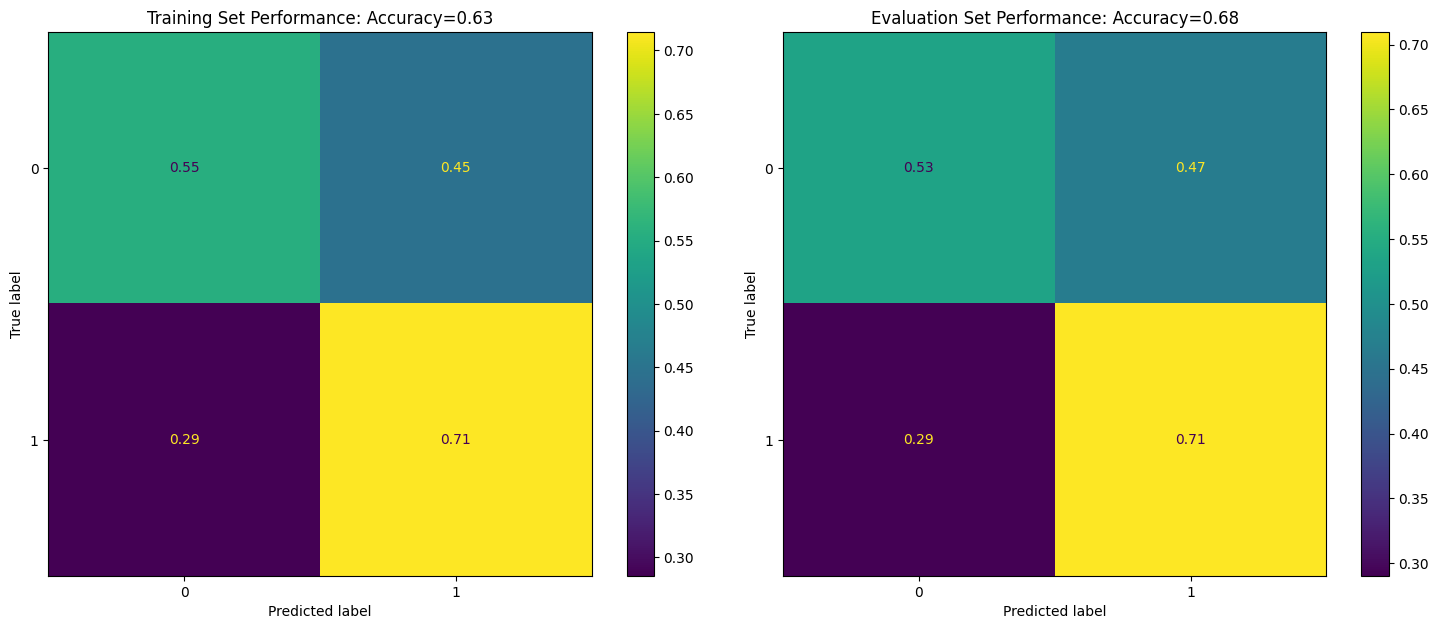


Evaluation Set Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.53      0.36     16948
           1       0.88      0.71      0.79     83319

    accuracy                           0.68    100267
   macro avg       0.58      0.62      0.57    100267
weighted avg       0.78      0.68      0.71    100267



In [ ]:
eval_classification_performance(mlp, X_train_scaled, y_train_resampled, test_X_scaled, y_test)

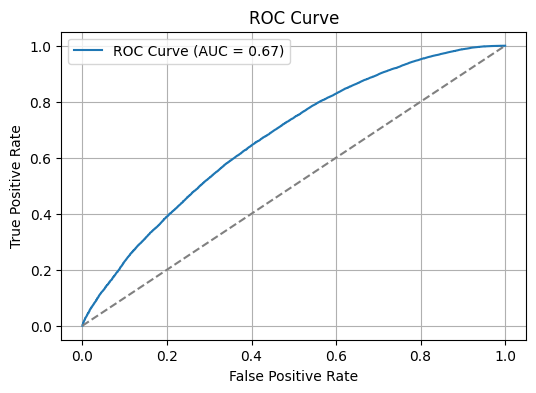

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(mlp, train_X_scaled, y_train, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))

plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(Encoded_train_X.columns)[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.show()

NameError: name 'best_mlp' is not defined

In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=train_X_scaled,
    feature_names=Encoded_train_X.columns,
    class_names=np.unique(train_Y),
    mode='classification'
)

i = 0  # index of instance to explain
exp = explainer.explain_instance(train_X_scaled[i], best_mlp.predict_proba)


MemoryError: Unable to allocate 4.97 MiB for an array with shape (651617,) and data type int64

[('VMake_0 <= -0.03', -0.35069629350222065), ('VYMM_0 <= -0.09', -0.25436282688569245), ('adjusted_price > 0.15', -0.1534753738308017), ('VMakeModel_1 <= -0.10', 0.0730569284014029), ('TaskName_7 <= -0.74', -0.0703826102441674), ('VYMM_2 <= -0.36', -0.06618151923244339), ('VMake_4 <= -0.37', 0.06305412731089415), ('VMake_3 <= -0.18', -0.058417043184514836), ('TaskName_0 <= -0.04', 0.05332665874486834), ('VYear_0 <= -0.03', -0.045531854813953034)]


C:\Users\delac\AppData\Local\Temp\ipykernel_13728\482656293.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


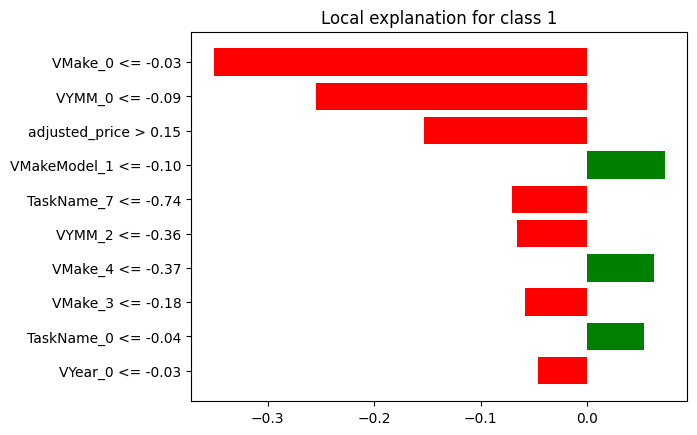

In [ ]:
print(exp.as_list())  # Outputs explanation as a list of (feature, weight) pairs
fig = exp.as_pyplot_figure()
fig.show()